<a href="https://colab.research.google.com/github/TrevorIkky/Classwork-ANN-Task/blob/main/Classwork_ANN_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
from google.colab import files
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.linear_model import LassoCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.models import Model
 
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [ ]:
files.upload()

Saving Nairobi Office Price Ex.csv to Nairobi Office Price Ex (21).csv


{'Nairobi Office Price Ex.csv': b'LOC,FUR,AMB,PROX_SCH,PROX_ROAD,PROX_MALL,WATER,HK_SER,SIZE,PRICE\r\nkaren,yes,serene,no,yes,yes,yes,yes,32.50234527,31.70700585\r\nmadaraka,yes,semi_serene,yes,yes,yes,no,no,53.42680403,68.77759598\r\nkaren,no,noisy,no,yes,yes,yes,yes,61.53035803,62.5623823\r\nkaren,yes,semi_serene,no,no,no,yes,yes,47.47563963,71.54663223\r\nburuburu,no,semi_serene,no,yes,yes,yes,yes,59.81320787,87.23092513\r\ndonholm,no,serene,no,no,yes,no,yes,55.14218841,78.21151827\r\nlangata,no,very_noisy,yes,yes,no,no,yes,52.21179669,79.64197305\r\nlangata,yes,serene,no,no,yes,yes,no,39.29956669,59.17148932\r\ndonholm,yes,semi_serene,yes,no,no,yes,no,48.10504169,75.3312423\r\nkaren,yes,serene,no,no,no,no,no,52.55001444,71.30087989\r\nmadaraka,yes,noisy,yes,yes,no,yes,yes,45.41973014,55.16567715\r\nlangata,no,semi_serene,yes,no,yes,yes,yes,54.35163488,82.47884676\r\nburuburu,yes,semi_serene,yes,yes,no,no,no,44.1640495,62.00892325\r\nkaren,yes,semi_serene,yes,yes,yes,yes,yes,58.1684

# **Nairobi Office Price Ex.csv**
Group cols according to nominal, ordinal & numerical types.
Define target variable: PRICE

In [ ]:
dataset = pd.read_csv('Nairobi Office Price Ex.csv')
cols_nominal = ['LOC','FUR','WATER','HK_SER']
cols_ordinal = ['AMB','PROX_SCH','PROX_ROAD','PROX_MALL']
cols_numerical = ['SIZE']
target_Y = ['PRICE']
dataset.head()

,LOC,FUR,AMB,PROX_SCH,PROX_ROAD,PROX_MALL,WATER,HK_SER,SIZE,PRICE
0,karen,yes,serene,no,yes,yes,yes,yes,32.502345,31.707006
1,madaraka,yes,semi_serene,yes,yes,yes,no,no,53.426804,68.777596
2,karen,no,noisy,no,yes,yes,yes,yes,61.530358,62.562382
3,karen,yes,semi_serene,no,no,no,yes,yes,47.475640,71.546632
4,buruburu,no,semi_serene,no,yes,yes,yes,yes,59.813208,87.230925


# **Encoding**
Integer encoding for values in ordinal cols

In [ ]:
for col in cols_ordinal:
  label_encoder = LabelEncoder()
  updated_col = label_encoder.fit_transform(dataset[col])
  dataset[col] = updated_col

dataset.head()

,LOC,FUR,AMB,PROX_SCH,PROX_ROAD,PROX_MALL,WATER,HK_SER,SIZE,PRICE
0,karen,yes,2,0,1,1,yes,yes,32.502345,31.707006
1,madaraka,yes,1,1,1,1,no,no,53.426804,68.777596
2,karen,no,0,0,1,1,yes,yes,61.530358,62.562382
3,karen,yes,1,0,0,0,yes,yes,47.475640,71.546632
4,buruburu,no,1,0,1,1,yes,yes,59.813208,87.230925


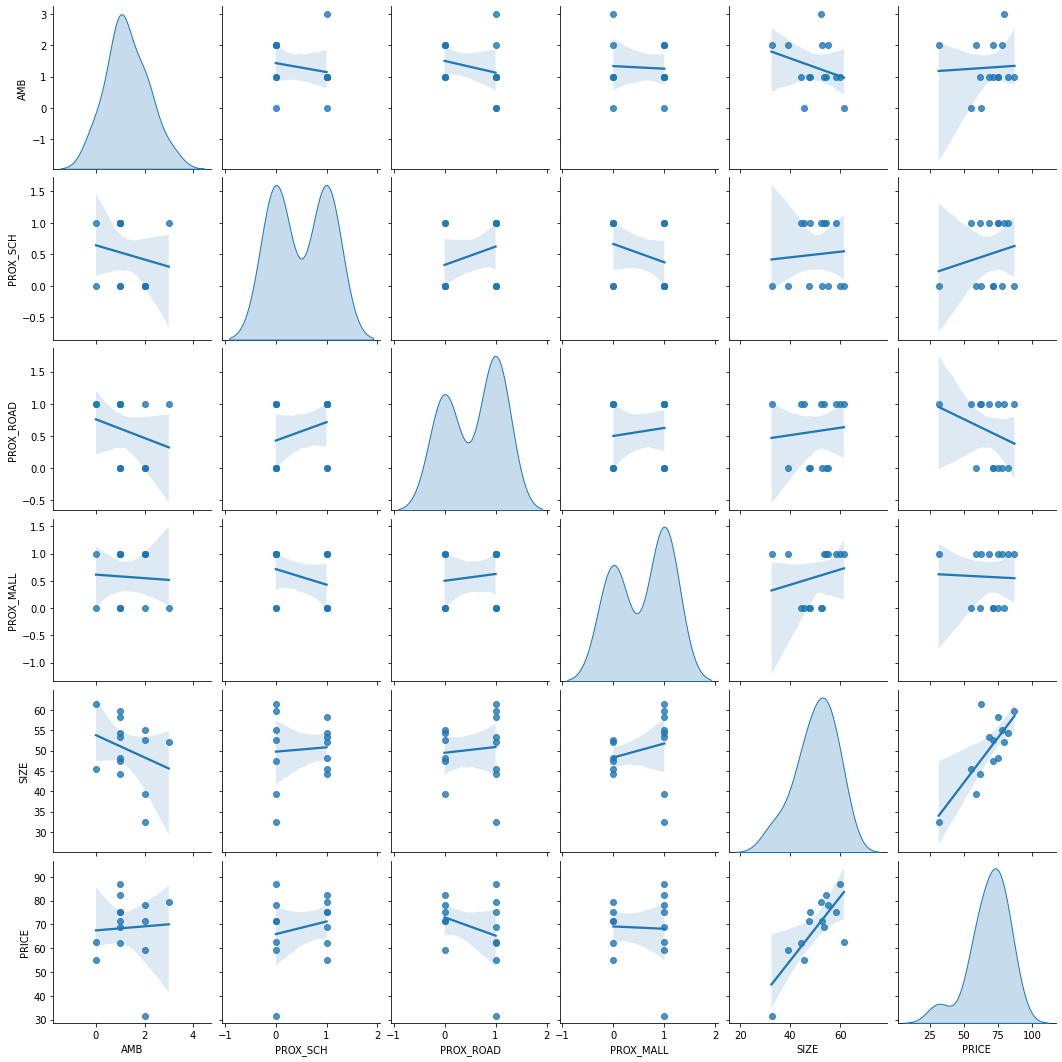

In [ ]:
"""
Check for linear dependencies between cols using pairplot
"""
sns.pairplot(dataset, kind='reg', diag_kind='kde')

In [ ]:
dummies = pd.get_dummies(dataset[cols_nominal])
dataset = pd.concat([dummies, dataset], axis=1)
dataset.drop(cols_nominal, axis=1, inplace=True)
dataset.head()

,LOC_buruburu,LOC_donholm,LOC_karen,LOC_langata,LOC_madaraka,FUR_no,FUR_yes,WATER_no,WATER_yes,HK_SER_no,HK_SER_yes,AMB,PROX_SCH,PROX_ROAD,PROX_MALL,SIZE,PRICE
0,0,0,1,0,0,0,1,0,1,0,1,2,0,1,1,32.502345,31.707006
1,0,0,0,0,1,0,1,1,0,1,0,1,1,1,1,53.426804,68.777596
2,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1,61.530358,62.562382
3,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,47.475640,71.546632
4,1,0,0,0,0,1,0,0,1,0,1,1,0,1,1,59.813208,87.230925


# **Power Transform Functions**
These functions convert the distribution of feature values to match a gaussian distribution. Asymmetric feature values are converted to more symmetric values to boost the performance of linear models.


In [ ]:

transformer = PowerTransformer()
transformed_dataset = transformer.fit_transform(dataset)
dataset = pd.DataFrame(transformed_dataset, columns=dataset.columns)
dataset.head()

,LOC_buruburu,LOC_donholm,LOC_karen,LOC_langata,LOC_madaraka,FUR_no,FUR_yes,WATER_no,WATER_yes,HK_SER_no,HK_SER_yes,AMB,PROX_SCH,PROX_ROAD,PROX_MALL,SIZE,PRICE
0,-0.408248,-0.408248,1.341641,-0.522233,-0.408248,-0.745356,0.745356,-0.745356,0.745356,-0.745356,0.745356,0.907859,-1.0,0.866025,0.866025,-1.910520,-2.060592
1,-0.408248,-0.408248,-0.745356,-0.522233,2.449490,-0.745356,0.745356,1.341641,-1.341641,1.341641,-1.341641,-0.297095,1.0,0.866025,0.866025,0.316823,-0.178865
2,-0.408248,-0.408248,1.341641,-0.522233,-0.408248,1.341641,-1.341641,-0.745356,0.745356,-0.745356,0.745356,-1.761084,-1.0,0.866025,0.866025,1.699631,-0.673078
3,-0.408248,-0.408248,1.341641,-0.522233,-0.408248,-0.745356,0.745356,-0.745356,0.745356,-0.745356,0.745356,-0.297095,-1.0,-1.154701,-1.154701,-0.500955,0.069057
4,2.449490,-0.408248,-0.745356,-0.522233,-0.408248,1.341641,-1.341641,-0.745356,0.745356,-0.745356,0.745356,-0.297095,-1.0,0.866025,0.866025,1.379363,1.827632


# **Lasso Regularization**
Converts the coefficients (weights) of less important feature maps to 0.
Uses L1 norm. <br>
$\hat{y} = w_1x_1 + w_2x_2 + ... w_nx_n$ where $w_i$ is the coeffient applied to linearly transform values.
<br>
$loss(y, \hat{y}) + \alpha\sum_{i=1}^n |w_i|$

Additionaly, from the dataset take the price col as the target variable dataset y and remove the price col to form X dataset and

In [ ]:
y = dataset["PRICE"]
X = dataset.drop("PRICE", axis=1)
y

0    -2.060592
1    -0.178865
2    -0.673078
3     0.069057
4     1.827632
5     0.740273
6     0.898605
7    -0.908206
8     0.436974
9     0.046338
10   -1.156423
11    1.228105
12   -0.713071
13    0.443250
Name: PRICE, dtype: float64

In [ ]:
"""
Define a linear model, 
"""
C = LassoCV()
C.fit(X, y)
col_indices = [i for i, x in enumerate(C.coef_) if x != 0]
print(f'Selected cols: {len(col_indices)} of {len(C.coef_)}')
print(f'Cols: {X.columns[col_indices]}')

Selected cols: 3 of 16
Cols: Index(['FUR_no', 'FUR_yes', 'SIZE'], dtype='object')


# **L1 Embedding**
Features who's coefficients = 0 are are split off the dataset leaving the $n$ most important features to be passed to the ANN

In [ ]:
new_cols = X.columns[col_indices]
X = X[new_cols]
X_ds = X.to_numpy()
y_ds = y.to_numpy()

Define a $tf.keras.Model$ Input shape is (None, 2) and three dense layers.
The first 2 layers have an activation function $RELU(\hat{y}) = max(\hat{y}, 0)$The last layer does not have an activation function.
Total number of trainable params = 2,369

In [ ]:
@tf.function
def ANN() -> Model:
  I = Input(shape=(3,))
  x = Dense(64, activation='relu')(I)
  x = Dense(32, activation='relu')(x)
  x = Dense(1)(x)
  return Model(I, x)  

model = ANN()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
_________________________________________________________________


# **Model compilation & training**
Compile the model using the stochastic gradient descent as the optimizer, huber loss (loss function less sensitive to outliers) and mean squared error as the metrics. Early stopping is a $keras.callback$ that allows us to set an arbitrarily large epock size, the model will automatically stop when the loss value does not reduce for $n$ epochs.
The last 2 rows in the dataset are not used in training to test the model's generalization

In [ ]:

model.compile(optimizer=SGD(learning_rate=0.1), loss=Huber(), metrics='mse')
early_stopping = EarlyStopping(patience=2, monitor='loss')
history = model.fit(X_ds[:-2], y_ds[:-2], batch_size=15, epochs=300, callbacks=[early_stopping])

Epoch 1/300
1/1 [==============================] - 0s 56ms/step - loss: 0.4703 - mse: 1.0724
Epoch 2/300
1/1 [==============================] - 0s 24ms/step - loss: 0.4092 - mse: 0.9046
Epoch 3/300
1/1 [==============================] - 0s 22ms/step - loss: 0.3715 - mse: 0.8042
Epoch 4/300
1/1 [==============================] - 0s 21ms/step - loss: 0.3442 - mse: 0.7331
Epoch 5/300
1/1 [==============================] - 0s 26ms/step - loss: 0.3222 - mse: 0.6789
Epoch 6/300
1/1 [==============================] - 0s 19ms/step - loss: 0.3041 - mse: 0.6366
Epoch 7/300
1/1 [==============================] - 0s 19ms/step - loss: 0.2888 - mse: 0.6028
Epoch 8/300
1/1 [==============================] - 0s 19ms/step - loss: 0.2758 - mse: 0.5760
Epoch 9/300
1/1 [==============================] - 0s 25ms/step - loss: 0.2651 - mse: 0.5557
Epoch 10/300
1/1 [==============================] - 0s 26ms/step - loss: 0.2547 - mse: 0.5371
Epoch 11/300
1/1 [==============================] - 0s 28ms/step - lo

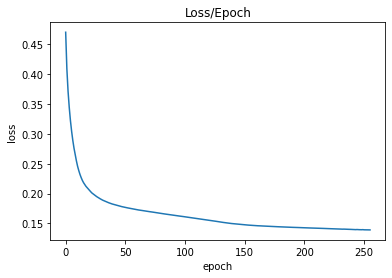

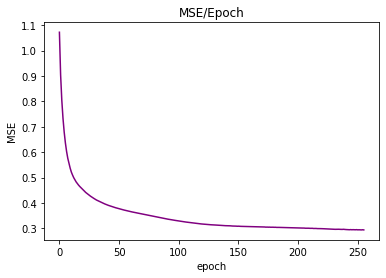

In [ ]:
plt.plot(history.history["loss"])
plt.title('Loss/Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
print('\n')
plt.plot(history.history["mse"], color="purple")
plt.title('MSE/Epoch')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.show()

In [ ]:
eval_history = model.evaluate(X_ds, y_ds, batch_size=15)
print(f'Loss: {eval_history[0]}, MSE: {eval_history[1]} ')

1/1 [==============================] - 0s 26ms/step - loss: 0.1351 - mse: 0.2836
Loss: 0.13505737483501434, MSE: 0.2836417853832245 


# **Model prediction & plots**
The last 2 rows are used for prediction and a multi-bar graph compares the magnitute between a true value and a predicted value for the 2 instances passed to it.

In [ ]:
X_predict = X_ds[-2: ]
y_true = y_ds[-2: ]
P = model.predict(X_predict).squeeze()
print(f'True vals:\n{y_true}\nvs.\nPredicted vals:\n{P}')

True vals:
[-0.71307098  0.44325019]
vs.
Predicted vals:
[-0.60027313 -0.21494822]


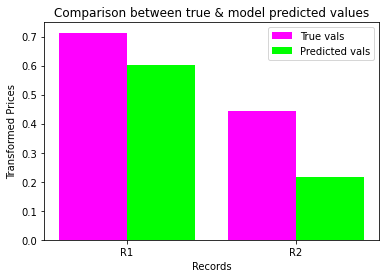

In [ ]:
X = ['R1', 'R2']
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, np.abs(y_true), 0.4, label = 'True vals', color='magenta')
plt.bar(X_axis + 0.2, np.abs(P), 0.4, label = 'Predicted vals', color='lime')
plt.xticks(X_axis, X)
plt.xlabel("Records")
plt.ylabel("Transformed Prices")
plt.title("Comparison between true & model predicted values")
plt.legend()
plt.show()